### feature_selection.ipynb: 
goal: clean, select, and engineer features for modeling

In [254]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
pd.set_option('display.max_columns', 120)

In [192]:
df = pd.read_csv('../data/ufc-master.csv')
print(df.shape)
df.head()

(6528, 118)


,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,TitleBout,WeightClass,Gender,NumberOfRounds,BlueCurrentLoseStreak,BlueCurrentWinStreak,BlueDraws,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueLongestWinStreak,BlueLosses,BlueTotalRoundsFought,BlueTotalTitleBouts,BlueWinsByDecisionMajority,BlueWinsByDecisionSplit,BlueWinsByDecisionUnanimous,BlueWinsByKO,BlueWinsBySubmission,BlueWinsByTKODoctorStoppage,BlueWins,BlueStance,BlueHeightCms,BlueReachCms,BlueWeightLbs,RedCurrentLoseStreak,RedCurrentWinStreak,RedDraws,RedAvgSigStrLanded,RedAvgSigStrPct,RedAvgSubAtt,RedAvgTDLanded,RedAvgTDPct,RedLongestWinStreak,RedLosses,RedTotalRoundsFought,RedTotalTitleBouts,RedWinsByDecisionMajority,RedWinsByDecisionSplit,RedWinsByDecisionUnanimous,RedWinsByKO,RedWinsBySubmission,RedWinsByTKODoctorStoppage,RedWins,RedStance,RedHeightCms,RedReachCms,RedWeightLbs,RedAge,BlueAge,LoseStreakDif,WinStreakDif,LongestWinStreakDif,WinDif,LossDif,TotalRoundDif,TotalTitleBoutDif,KODif,SubDif,HeightDif,ReachDif,AgeDif,SigStrDif,AvgSubAttDif,AvgTDDif,EmptyArena,BMatchWCRank,RMatchWCRank,RWFlyweightRank,RWFeatherweightRank,RWStrawweightRank,RWBantamweightRank,RHeavyweightRank,RLightHeavyweightRank,RMiddleweightRank,RWelterweightRank,RLightweightRank,RFeatherweightRank,RBantamweightRank,RFlyweightRank,RPFPRank,BWFlyweightRank,BWFeatherweightRank,BWStrawweightRank,BWBantamweightRank,BHeavyweightRank,BLightHeavyweightRank,BMiddleweightRank,BWelterweightRank,BLightweightRank,BFeatherweightRank,BBantamweightRank,BFlyweightRank,BPFPRank,BetterRank,Finish,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,True,Flyweight,MALE,5,0,0,0,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,Orthodox,172.72,175.26,125,0,6,0,4.41,0.49,0.8,2.61,0.47,6,3,42,3,0,2,4,2,4,0,12,Orthodox,165.10,170.18,125,34,31,0,-6,-6,-12,-3,-42,-3,-2,-4,7.62,5.08,-3,-4.41,-0.8,-2.61,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,SUB,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,False,Welterweight,MALE,3,0,8,0,5.50,0.55,0.3,0.77,0.55,8,0,20,0,0,1,4,3,0,0,8,Orthodox,190.50,187.96,170,0,6,0,4.12,0.61,1.8,1.49,0.29,6,0,11,0,0,0,0,1,5,0,6,Orthodox,185.42,195.58,170,30,27,0,2,2,2,0,9,0,2,-5,5.08,-7.62,-3,1.38,-1.5,-0.72,NaN,7.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,False,Heavyweight,MALE,3,0,4,0,5.13,0.57,0.2,0.45,0.63,4,4,44,0,0,1,4,6,1,0,12,Orthodox,200.66,203.20,250,0,1,0,5.49,0.60,0.5,0.58,0.21,7,2,33,3,0,0,3,4,2,0,9,Orthodox,193.04,205.74,245,34,36,0,3,-3,3,2,11,-3,2,-1,7.62,-2.54,2,-0.36,-0.3,-0.13,NaN,3.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,S-DEC,NaN,3.0,5:00,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,3,2,0,0,3.74,0.44,0.5,0.47,0.25,1,2,7,0,0,0,0,0,1,0,1,Southpaw,175.26,177.80,145,1,0,0,2.30,0.58,1.6,3.45,0.41,6,2,22,0,1,0,5,0,1,0,7,Southpaw,177.80,177.80,145,30,36,1,0,-5,-6,0,-15,0,0,0,-2.54,0.00,6,1.44,-1.1,-2.98,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,KO/TKO,Elbows,3.0,0:39,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,False,Feathe

In [193]:
null_pct = df.isnull().mean().sort_values(ascending = False)
high_null_cols = null_pct[null_pct > 0.7].index.tolist()

print(f'\n dropping {len(high_null_cols)} columns with >95% missing values:\n')
for col in high_null_cols:
    print(f' - {col} ({null_pct[col]*100:.1f}% missing)')

df = df.drop(columns = high_null_cols)


 dropping 28 columns with >95% missing values:

 - BWFeatherweightRank (100.0% missing)
 - RWFeatherweightRank (99.9% missing)
 - BPFPRank (99.0% missing)
 - BWFlyweightRank (98.9% missing)
 - RWFlyweightRank (98.5% missing)
 - BWStrawweightRank (98.5% missing)
 - BWBantamweightRank (98.4% missing)
 - BBantamweightRank (98.2% missing)
 - BWelterweightRank (98.2% missing)
 - BLightHeavyweightRank (98.2% missing)
 - BLightweightRank (98.2% missing)
 - BFeatherweightRank (98.1% missing)
 - BFlyweightRank (98.0% missing)
 - BMiddleweightRank (97.9% missing)
 - RWStrawweightRank (97.8% missing)
 - BHeavyweightRank (97.7% missing)
 - RWBantamweightRank (97.6% missing)
 - RFeatherweightRank (97.3% missing)
 - RBantamweightRank (97.2% missing)
 - RMiddleweightRank (97.2% missing)
 - RLightHeavyweightRank (97.2% missing)
 - RLightweightRank (97.2% missing)
 - RHeavyweightRank (97.2% missing)
 - RFlyweightRank (97.1% missing)
 - RWelterweightRank (97.1% missing)
 - RPFPRank (96.1% missing)
 - B

In [194]:
to_drop = [
    'Date', 'Location', 'Country',   # high-cardinality, hard to model
    'FinishDetails',                 # ultra granular
    'FinishRoundTime'                # not useful before fight
]

df = df.drop(columns = [col for col in to_drop if col in df.columns])

In [195]:
df['BlueStance'].unique()

array(['Orthodox', 'Southpaw', 'Switch', nan, 'Switch ', 'Open Stance'],
      dtype=object)

In [196]:
df['RedStance'].unique()

array(['Orthodox', 'Southpaw', 'Switch', 'Open Stance'], dtype=object)

In [197]:
df['RedStance'] = df['RedStance'].fillna('Unknown')
df['BlueStance'] = df['BlueStance'].fillna('Unknown')

# combining unique values from both columns for consistent encoding
all_stances = pd.concat([df['RedStance'], df['BlueStance']]).unique()

stance_enc = LabelEncoder()
stance_enc.fit(all_stances)

# transforming both using same encoder
df['RedStance'] = stance_enc.transform(df['RedStance'])
df['BlueStance'] = stance_enc.transform(df['BlueStance'])

In [198]:
def american_to_decimal(odds):
    if odds > 0:
        return odds/100 + 1
    else:
        return 100/abs(odds) + 1

In [199]:
# transforming odds using the helper func
df['red_decimal_odds'] = df['RedOdds'].apply(american_to_decimal)
df['blue_decimal_odds'] = df['BlueOdds'].apply(american_to_decimal)
df['odds_difference'] = df['red_decimal_odds'] - df['blue_decimal_odds']

In [200]:
df['target'] = (df['Winner'] == 'Red').astype(int)

In [201]:
# accounting for 'experience'
df['fight_count_diff'] = (df['RedWins'] + df['RedLosses'] + df['RedDraws']) - \
                         (df['BlueWins'] + df['BlueLosses'] + df['BlueDraws'])

# accounting for win ratio
df['win_ratio_diff'] = (df['RedWins'] / (df['RedWins'] + df['RedLosses'] + 1e-5)) - \
                       (df['BlueWins'] / (df['BlueWins'] + df['BlueLosses'] + 1e-5))

df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Winner,TitleBout,WeightClass,Gender,NumberOfRounds,BlueCurrentLoseStreak,BlueCurrentWinStreak,BlueDraws,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueLongestWinStreak,BlueLosses,BlueTotalRoundsFought,BlueTotalTitleBouts,BlueWinsByDecisionMajority,BlueWinsByDecisionSplit,BlueWinsByDecisionUnanimous,BlueWinsByKO,BlueWinsBySubmission,BlueWinsByTKODoctorStoppage,BlueWins,BlueStance,BlueHeightCms,BlueReachCms,BlueWeightLbs,RedCurrentLoseStreak,RedCurrentWinStreak,RedDraws,RedAvgSigStrLanded,RedAvgSigStrPct,RedAvgSubAtt,RedAvgTDLanded,RedAvgTDPct,RedLongestWinStreak,RedLosses,RedTotalRoundsFought,RedTotalTitleBouts,RedWinsByDecisionMajority,RedWinsByDecisionSplit,RedWinsByDecisionUnanimous,RedWinsByKO,RedWinsBySubmission,RedWinsByTKODoctorStoppage,RedWins,RedStance,RedHeightCms,RedReachCms,RedWeightLbs,RedAge,BlueAge,LoseStreakDif,WinStreakDif,LongestWinStreakDif,WinDif,LossDif,TotalRoundDif,TotalTitleBoutDif,KODif,SubDif,HeightDif,ReachDif,AgeDif,SigStrDif,AvgSubAttDif,AvgTDDif,EmptyArena,BetterRank,Finish,FinishRound,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,red_decimal_odds,blue_decimal_odds,odds_difference,target,fight_count_diff,win_ratio_diff
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,Red,True,Flyweight,MALE,5,0,0,0,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,1,172.72,175.26,125,0,6,0,4.41,0.49,0.8,2.61,0.47,6,3,42,3,0,2,4,2,4,0,12,1,165.10,170.18,125,34,31,0,-6,-6,-12,-3,-42,-3,-2,-4,7.62,5.08,-3,-4.41,-0.8,-2.61,NaN,Red,SUB,2.0,425.0,300.0,800.0,150.0,2500.0,400.0,350.0,1.400000,3.15,-1.750000,1,15,7.999995e-01
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,Red,False,Welterweight,MALE,3,0,8,0,5.50,0.55,0.3,0.77,0.55,8,0,20,0,0,1,4,3,0,0,8,1,190.50,187.96,170,0,6,0,4.12,0.61,1.8,1.49,0.29,6,0,11,0,0,0,0,1,5,0,6,1,185.42,195.58,170,30,27,0,2,2,2,0,9,0,2,-5,5.08,-7.62,-3,1.38,-1.5,-0.72,NaN,Red,U-DEC,5.0,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0,1.476190,3.95,-2.473810,1,-2,-4.166655e-07
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,Red,False,Heavyweight,MALE,3,0,4,0,5.13,0.57,0.2,0.45,0.63,4,4,44,0,0,1,4,6,1,0,12,1,200.66,203.20,250,0,1,0,5.49,0.60,0.5,0.58,0.21,7,2,33,3,0,0,3,4,2,0,9,1,193.04,205.74,245,34,36,0,3,-3,3,2,11,-3,2,-1,7.62,-2.54,2,-0.36,-0.3,-0.13,NaN,Red,S-DEC,3.0,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0,1.263158,4.00,-2.736842,1,-5,6.818154e-02
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,Red,False,Featherweight,MALE,3,2,0,0,3.74,0.44,0.5,0.47,0.25,1,2,7,0,0,0,0,0,1,0,1,2,175.26,177.80,145,1,0,0,2.30,0.58,1.6,3.45,0.41,6,2,22,0,1,0,5,0,1,0,7,2,177.80,177.80,145,30,36,1,0,-5,-6,0,-15,0,0,0,-2.54,0.00,6,1.44,-1.1,-2.98,NaN,Red,KO/TKO,3.0,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0,1.105263,7.25,-6.144737,1,6,4.444447e-01
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,Blue,False,Featherweight,MALE,3,0,1,1,4.41,0.53,0.8,0.75,0.37,3,3,15,0,0,0,0,4,0,0,4,1,177.80,177.80,145,0,1,0,6.25,0.46,1.0,1.00,0.41,3,3,17,0,1,0,1,1,2,0,5,1,175.26,182.88,145,36,33,0,0,0,-1,0,-2,0,3,-2,2.54,-5.08,-3,-1.84,-0.2,-0.25,NaN,neither,KO/TKO,3.0,801.0,275.0,550.0,500.0,700.0,300.0,250.0,1.769231,2.10,-0.330769,0,0,5.357146e-02


In [202]:
drop_post_fight = [
    'Winner', 'WinnerName', 'Finish', 'FinishRound', 'TotalFightTimeSecs',
    'RedDecOdds', 'BlueDecOdds', 'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds',
]

drop_betting = ['RedOdds', 'BlueOdds', 'RedExpectedValue', 'BlueExpectedValue']

drop_redundant = [
    'RedWins', 'BlueWins', 'RedLosses', 'BlueLosses', 'RedDraws', 'BlueDraws',
    'RedAvgSigStrPct', 'BlueAvgSigStrPct', 'RedAvgSigStrLanded', 'BlueAvgSigStrLanded',
    'RedAvgTDLanded', 'BlueAvgTDLanded', 'RedAvgTDPct', 'BlueAvgTDPct',
    'RedAvgSubAtt', 'BlueAvgSubAtt'
]

drop_names = ['RedFighter', 'BlueFighter']

In [203]:
# combine all and drop
final_drop = drop_post_fight + drop_betting + drop_redundant + drop_names
df = df.drop(columns = [col for col in final_drop if col in df.columns])

In [204]:
df.columns

Index(['TitleBout', 'WeightClass', 'Gender', 'NumberOfRounds',
       'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueLongestWinStreak',
       'BlueTotalRoundsFought', 'BlueTotalTitleBouts',
       'BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit',
       'BlueWinsByDecisionUnanimous', 'BlueWinsByKO', 'BlueWinsBySubmission',
       'BlueWinsByTKODoctorStoppage', 'BlueStance', 'BlueHeightCms',
       'BlueReachCms', 'BlueWeightLbs', 'RedCurrentLoseStreak',
       'RedCurrentWinStreak', 'RedLongestWinStreak', 'RedTotalRoundsFought',
       'RedTotalTitleBouts', 'RedWinsByDecisionMajority',
       'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous', 'RedWinsByKO',
       'RedWinsBySubmission', 'RedWinsByTKODoctorStoppage', 'RedStance',
       'RedHeightCms', 'RedReachCms', 'RedWeightLbs', 'RedAge', 'BlueAge',
       'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
       'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
       'HeightDif'

In [205]:
df['is_title'] = df['TitleBout'].astype(int)

In [208]:
# to keep consistent stats, where we take red_stat - blue_stat, and not the other way around
df['age_diff'] = -df['AgeDif']
df['height_diff'] = -df['HeightDif']
df['reach_diff'] = -df['ReachDif']
df['wstreak_diff'] = -df['WinStreakDif']
df['sig_str_diff'] = -df['SigStrDif']
df['avg_sub_att_diff'] = -df['AvgSubAttDif']
df['avg_td_diff'] = -df['AvgTDDif']

In [291]:
sub_df = df[['odds_difference', 'fight_count_diff', 'win_ratio_diff',
            'is_title', 'age_diff', 'height_diff', 'reach_diff', 
            'wstreak_diff', 'sig_str_diff', 'avg_sub_att_diff',
            'avg_td_diff', 'RedStance', 'BlueStance', 'target']]

In [292]:
sub_df.head()

,odds_difference,fight_count_diff,win_ratio_diff,is_title,age_diff,height_diff,reach_diff,wstreak_diff,sig_str_diff,avg_sub_att_diff,avg_td_diff,RedStance,BlueStance,target
0,-1.750000,15,7.999995e-01,1,3,-7.62,-5.08,6,4.41,0.8,2.61,1,1,1
1,-2.473810,-2,-4.166655e-07,0,3,-5.08,7.62,-2,-1.38,1.5,0.72,1,1,1
2,-2.736842,-5,6.818154e-02,0,-2,-7.62,2.54,-3,0.36,0.3,0.13,1,1,1
3,-6.144737,6,4.444447e-01,0,-6,2.54,-0.00,0,-1.44,1.1,2.98,2,2,1
4,-0.330769,0,5.357146e-02,0,3,-2.54,5.08,0,1.84,0.2,0.25,1,1,0


In [293]:
sub_df.isnull().sum()

odds_difference     238
fight_count_diff      0
win_ratio_diff        0
is_title              0
age_diff              0
height_diff           0
reach_diff            0
wstreak_diff          0
sig_str_diff          0
avg_sub_att_diff      0
avg_td_diff           0
RedStance             0
BlueStance            0
target                0
dtype: int64

## Modeling:

In [294]:
copy = sub_df.copy()
copy = copy.dropna(subset = ['odds_difference'])

In [301]:
X = copy.drop(columns=['target'])
y = copy['target']

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [313]:
mlp = MLPClassifier(hidden_layer_sizes = (32, 16, 16), activation = 'relu', max_iter = 300, random_state = 42)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_mlp)

accuracy

0.6359300476947536

In [314]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. train logistic regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# 5. predictions
y_pred = clf.predict(X_test_scaled)

# 6. evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       518
           1       0.69      0.81      0.74       740

    accuracy                           0.67      1258
   macro avg       0.66      0.64      0.64      1258
weighted avg       0.66      0.67      0.66      1258



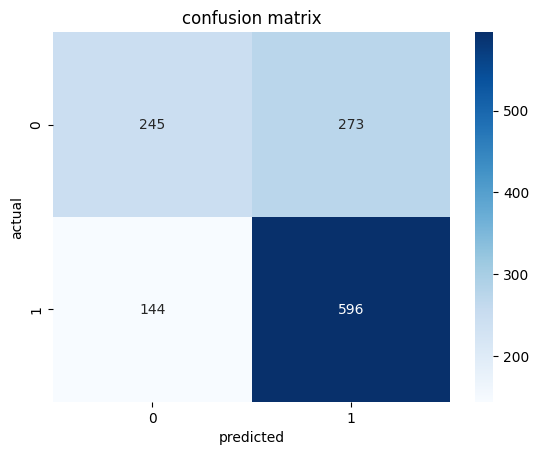


📈 top features by importance:

             feature  coefficient
0    odds_difference    -0.853778
2     win_ratio_diff    -0.110983
10       avg_td_diff     0.097244
7       wstreak_diff     0.090834
6         reach_diff     0.074243
9   avg_sub_att_diff     0.063403
1   fight_count_diff    -0.059974
11         RedStance     0.035470
4           age_diff     0.028056
12        BlueStance    -0.018297
3           is_title    -0.017461
5        height_diff     0.005453
8       sig_str_diff    -0.000689


/var/folders/53/6bk9szg91vg4209h0xj26_500000gp/T/ipykernel_84084/3576551048.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='coefficient', y='feature', palette='viridis')


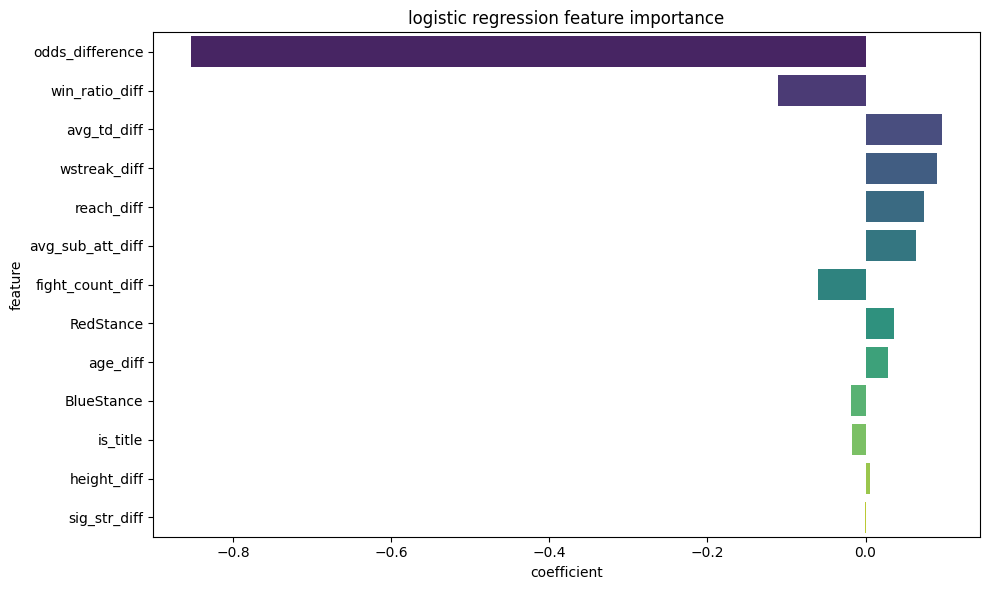

In [315]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

# 8. feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': clf.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

print("\n📈 top features by importance:\n")
print(feature_importance)

# optional: plot them
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='coefficient', y='feature', palette='viridis')
plt.title("logistic regression feature importance")
plt.tight_layout()
plt.show()

📊 Random Forest Report:
              precision    recall  f1-score   support

           0       0.62      0.47      0.53       518
           1       0.68      0.79      0.73       740

    accuracy                           0.66      1258
   macro avg       0.65      0.63      0.63      1258
weighted avg       0.65      0.66      0.65      1258



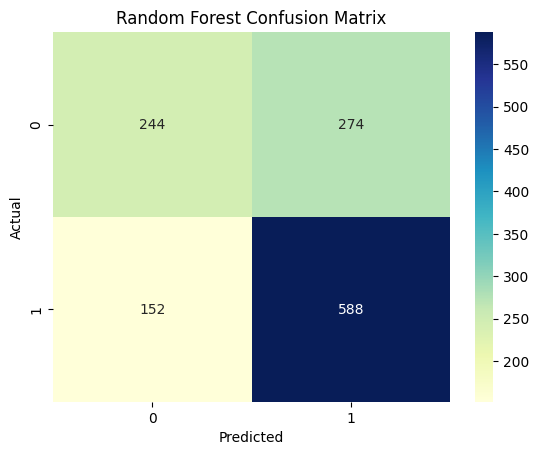

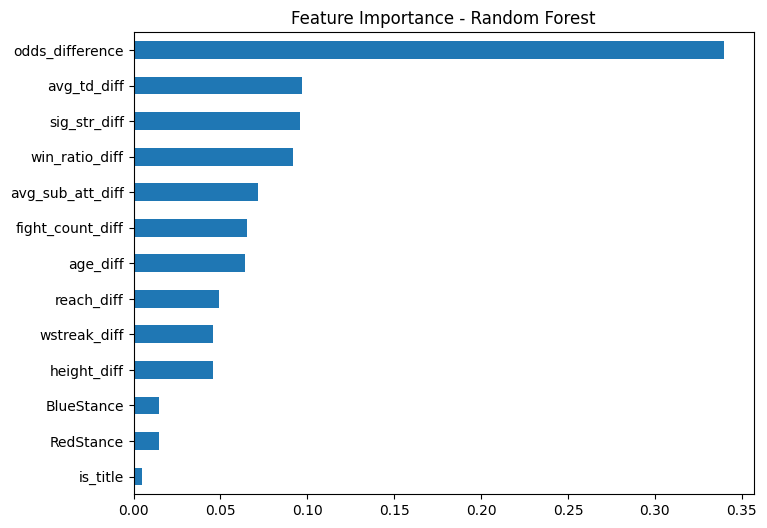

In [316]:
from sklearn.ensemble import RandomForestClassifier

# try RF
rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# eval
print("📊 Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# feature importance
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance - Random Forest")
plt.show()


Notes:

- Out of the three classifiers, it seems that Random Forests or a Neural Network work best.

- Attempting to predict using WinnerName as Y gives very low accuracy below 5%

In [255]:
upcoming = pd.read_csv('upcoming.csv')
upcoming['WeightClass'] = label_enc.fit_transform(upcoming['WeightClass'])

# match between Weidman and Anders was cancelled
december_match = upcoming.loc[6, ['RedOdds', 'BlueOdds','LossDif','SigStrDif','ReachDif','AvgTDDif','KODif','SubDif', 'WeightClass']]
upcoming.drop(6, inplace = True)
upcoming

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Jon Jones,Stipe Miocic,-625,455,16.0000,455.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,400,1400,200,3500,120,700
1,Charles Oliveira,Michael Chandler,-258,210,38.7597,210.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,1200,1100,130,900,215,380
2,Bo Nickal,Paul Craig,-1200,750,8.3333,750.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,700,3000,175,1400,-150,3000
3,Viviane Araujo,Karine Silva,240,-298,240.0000,33.5570,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,300,100,2000,300,2000,750
4,Mauricio Ruffy,James Llontop,-900,600,11.1111,600.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,180,1200,800,3500,-150,1800
5,Jonathan Martinez,Marcus McGhee,114,-135,114.0000,74.0741,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,215,250,1400,1400,500,225
7,Jim Miller,Damon Jackson,185,-225,185.0000,44.4444,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,550,130,900,400,500,500
8,David Onama,Roberto Romero,-1350,800,7.4074,800.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,275,1400,275,4000,-120,2200
9,Marcin Tybura,Jhonata Diniz,-115,-105,86.9565,95.2381,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,350,650,300,2200,450,165
10,Mickey Gall,Ramiz Brahimaj,-166,140,60.2410,140.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,180,300,380,550,450,1100


In [256]:
# manually adding in the Winner for the upcoming dataset according to https://www.ufc.com/event/ufc-309
winners = ['Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']
upcoming['Winner'] = winners
upcoming

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Jon Jones,Stipe Miocic,-625,455,16.0000,455.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,400,1400,200,3500,120,700
1,Charles Oliveira,Michael Chandler,-258,210,38.7597,210.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,1200,1100,130,900,215,380
2,Bo Nickal,Paul Craig,-1200,750,8.3333,750.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,700,3000,175,1400,-150,3000
3,Viviane Araujo,Karine Silva,240,-298,240.0000,33.5570,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,300,100,2000,300,2000,750
4,Mauricio Ruffy,James Llontop,-900,600,11.1111,600.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,180,1200,800,3500,-150,1800
5,Jonathan Martinez,Marcus McGhee,114,-135,114.0000,74.0741,2024-11-16,"New York City, New York, USA",USA,Blue,...,NaN,NaN,NaN,NaN,215,250,1400,1400,500,225
7,Jim Miller,Damon Jackson,185,-225,185.0000,44.4444,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,550,130,900,400,500,500
8,David Onama,Roberto Romero,-1350,800,7.4074,800.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,275,1400,275,4000,-120,2200
9,Marcin Tybura,Jhonata Diniz,-115,-105,86.9565,95.2381,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,350,650,300,2200,450,165
10,Mickey Gall,Ramiz Brahimaj,-166,140,60.2410,140.0000,2024-11-16,"New York City, New York, USA",USA,Blue,...,NaN,NaN,NaN,NaN,180,300,380,550,450,1100


In [257]:
x_upc = upcoming[['RedOdds', 'BlueOdds','LossDif','SigStrDif','ReachDif','AvgTDDif','KODif','SubDif', 'WeightClass']]

upcoming_pred = mlp.predict(x_upc)
mlp_accuracy = accuracy_score(winners, upcoming_pred)

# rfc_pred = rfc.predict(x_upc)
# rfc_accuracy = accuracy_score(winners, rfc_pred)

# dtc_pred = dtc.predict(x_upc)
# dtc_accuracy = accuracy_score(winners, dtc_pred)

print(f"MLP Test Accuracy for recent matches: {mlp_accuracy * 100:.2f}%")
# print(f"RFC Test Accuracy for recent matches: {rfc_accuracy * 100:.2f}%")
# print(f"DTC Test Accuracy for recent matches: {dtc_accuracy * 100:.2f}%")

MLP Test Accuracy for recent matches: 66.67%


In [258]:
upcoming['Predictions'] = upcoming_pred
predictions = upcoming.apply(lambda x: x['BlueFighter'] if x['Predictions'] == 'Blue' else x['RedFighter'], axis=1)
actual = upcoming.apply(lambda x: x['BlueFighter'] if x['Winner'] == 'Blue' else x['RedFighter'], axis=1)

comparison = pd.DataFrame({'model_predictions': predictions, 'actual_results': actual})
comparison

,model_predictions,actual_results
0,Jon Jones,Jon Jones
1,Charles Oliveira,Charles Oliveira
2,Bo Nickal,Bo Nickal
3,Karine Silva,Viviane Araujo
4,Mauricio Ruffy,Mauricio Ruffy
5,Marcus McGhee,Marcus McGhee
7,Damon Jackson,Jim Miller
8,David Onama,David Onama
9,Jhonata Diniz,Marcin Tybura
10,Mickey Gall,Ramiz Brahimaj


In [259]:
#prediction for Dec. 7
mlp.predict(december_match.to_numpy().reshape(1, -1))

/Users/U.M/Downloads/ufc-project/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


array(['Blue'], dtype='<U4')

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature_counts = range(1, X.shape[1] + 1)  # Test with 1 to all features
accuracies = []

# Train and evaluate models with increasing number of features
for count in feature_counts:
    # Select the first 'count' features
    X_subset = X.iloc[:, :count]
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_subset, Y, test_size=0.25, shuffle=True)
    
    # Train the model
    mlp = MLPClassifier(hidden_layer_sizes=(32, 16, 16), activation='relu', max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Elbow Graph for Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

In [264]:
sns.heatmap(ufc_data.isnull(), yticklabels=False)
plt.title("Heatmap for NaN values in our dataset")
plt.show()

NameError: name 'sns' is not defined

In [18]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use the same code you already have for data preprocessing and model training.
# Assuming `mlp` is your trained MLP model and you've already split the data.

def predict_winner_terminal():
    print("Enter the following features for the fighters:")
    
    try:
        red_odds = float(input("Fighter 1 Odds: "))
        blue_odds = float(input("Fighter 2 Odds: "))
        loss_dif = float(input("Loss Difference(Fighter 1 - Fighter 2): "))
        sig_str_dif = float(input("Significant Strikes Difference(Fighter 1 - Fighter 2): "))
        reach_dif = float(input("Reach Difference(Fighter 1 - Fighter 2): "))
        avg_td_dif = float(input("Average Takedown Difference(Fighter 1 - Fighter 2): "))
        ko_dif = float(input("Knockout Difference(Fighter 1 - Fighter 2): "))
        sub_dif = float(input("Submission Difference(Fighter 1 - Fighter 2): "))
        weight_class = int(input("Weight Class (as an integer): "))

        # Create the feature array
        features = np.array([[red_odds, blue_odds, loss_dif, sig_str_dif, reach_dif, avg_td_dif, ko_dif, sub_dif, weight_class]])
        
        # Predict the winner
        prediction = mlp.predict(features)
        winner = "Fighter 1" if prediction[0] == "Red" else "Fighter 2"

        print(f"The predicted winner is: {winner}")

    except ValueError:
        print("Invalid input. Please enter numeric values where required.")

# Run the function
if __name__ == "__main__":
    predict_winner_terminal()


Enter the following features for the fighters:
The predicted winner is: Fighter 2
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a713994-b4e1-47cc-89fe-2b6d51a0ee77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>